# Malaria Cell Classification Using Deep Learning

This project utilizes Convolutional Neural Networks (CNNs) to classify malaria-infected and uninfected cells from microscopic images. By leveraging deep learning techniques, this project aims to aid in faster and more accurate malaria diagnosis.

**Goals of the project**:
- To classify cells as either infected or uninfected.
- To achieve high classification accuracy using a CNN model.
- To demonstrate the potential of AI in healthcare diagnostics.


In [ ]:
#Importing LIB

import os
import cv2
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import random
import matplotlib.pyplot as plt
import time

## 1. Dataset Description

- **Source**: The dataset was obtained from the official [National Institutes of Health (NIH)](https://ceb.nlm.nih.gov/repositories/malaria-datasets/) database.
- **Dataset Details**:
  - Contains labeled images of **parasitized** (infected) and **uninfected** cells.
  - Total number of images: <ADD TOTAL IMAGES>.
  - Image size: 128x128 pixels.

In [150]:
data_path = "dataset"  #dataset path
num_classes = 2
num_samples = 1507     #number of samples
img_row_orig = 100     #row size of the image after reshaping
img_col_orig = 100     #col size of the image after reshaping
row_size = 224
col_size = 224
batch_size = 32
num_epoch = 1
channels = 3

In [151]:
# Method used to load data
def load_data():
    labels = os.listdir(data_path)    # labels name
    num_labels = len(labels)          # number of labels
    print("labels :", labels[:], "Number of Labels :", num_labels)


    X = np.ndarray((num_samples,img_row_orig,img_col_orig,3),dtype=np.uint8)    # declaring the array to store image
    y = np.zeros((num_samples,),dtype=np.uint8)   # declaring array to store labels
    i=0   # to iterate over each image
    j=0   # to iterate over each class
    for label in labels:
        imgs_name_data = os.listdir(os.path.join(data_path,label))  # getting all the image names
        total_imgs = len(imgs_name_data)      # total number of images
        print(label,total_imgs)
        count=0
        for img_name in imgs_name_data:     # selecting each image
            try:
                img = cv2.imread(os.path.join(data_path,label,img_name),cv2.IMREAD_COLOR) # reading image in RGB channel
                img = cv2.resize(img,(img_row_orig,img_col_orig)) # resizing each image into 100*100 size to store into X array
                img = np.array([img])   # converting the img into numpy array
                X[i] = img     # stacking all the images in the X array
                y[i] = j       # simultaneously labelling the image in the binary form
                i = i + 1
                count = count + 1
                if(i%100==0):
                    print("{0}/{1} images loaded".format(count,total_imgs))
            except AttributeError:
                print("")
        j = j + 1
    print("All images are loaded")
    return X,y

In [152]:
# Loading the images
X,y = load_data()

labels : ['Uninfected', 'Parasitized'] Number of Labels : 2
Uninfected 600
100/600 images loaded
200/600 images loaded
300/600 images loaded
400/600 images loaded
500/600 images loaded
600/600 images loaded
Parasitized 600
100/600 images loaded
200/600 images loaded
300/600 images loaded
400/600 images loaded
500/600 images loaded
600/600 images loaded
All images are loaded


In [153]:
# Printing the images
print("X : {}".format(X.shape))
print("y : {}".format(y.shape))

X : (1507, 100, 100, 3)
y : (1507,)


In [154]:
# Randomly Shuffling the images
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
y = y[s]

## 2. Data Preprocessing

Before training the model, the data needs to be loaded, preprocessed, and split into training, validation, and test sets.

**Steps**:
1. Load images and labels.
2. Resize images to 128x128 pixels for consistency.
3. Normalize pixel values to range [0, 1].
4. Split the data into 70% training, 20% validation, and 10% testing.

The following code implements these steps:


In [155]:
# Spliting the set into train set and test set
len_data = X.shape[0]
(X_train,X_test)=X[(int)(0.2*len_data):],X[:(int)(0.2*len_data)]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
train_len = X_train.shape[0]
test_len = X_test.shape[0]

In [156]:
(y_train,y_test) = y[(int)(0.2*len_data):],y[:(int)(0.2*len_data)]

In [157]:
# Printing all the shapes
print("X_train : {}".format(X_train.shape))
print("y_train : {}".format(y_train.shape))
print("X_test : {}".format(X_test.shape))
print("y_test : {}".format(y_test.shape))
num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]
print("num_train_samples : {}".format(num_train_samples))
print("num_test_samples : {}".format(num_test_samples))

X_train : (1206, 100, 100, 3)
y_train : (1206,)
X_test : (301, 100, 100, 3)
y_test : (301,)
num_train_samples : 1206
num_test_samples : 301


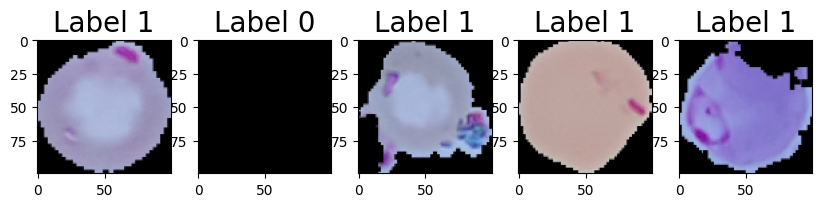

In [158]:
# Ploting the first 5 images of train set
plt.figure(figsize=(10,4))
for index,(image,label) in enumerate(zip(X_train[0:5],y_train[0:5])):
    plt.subplot(1,5,index+1)
    plt.imshow(np.reshape(image,(100,100,3)))
    plt.title('Label %d'%label,fontsize=20)
    plt.plot()

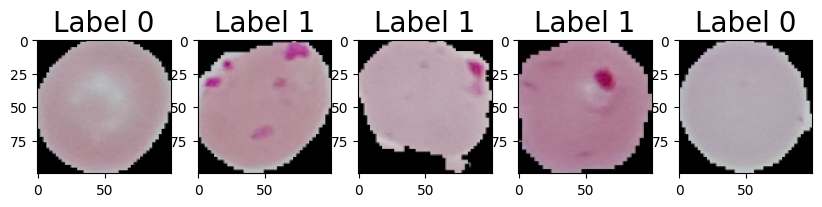

In [159]:
# Printing the first 5 images of test set
plt.figure(figsize=(10,4))
for index,(image,label) in enumerate(zip(X_test[0:5],y_test[0:5])):
    plt.subplot(1,5,index+1)
    plt.imshow(np.reshape(image,(100,100,3)))
    plt.title('Label %d'%label,fontsize=20)
    plt.plot()

In [160]:
#Doing One hot encoding as classifier has multiple classes
y_train= tensorflow.keras.utils.to_categorical(y_train,num_classes)
y_test= tensorflow.keras.utils.to_categorical(y_test,num_classes)

## 3. Model Architecture

The Convolutional Neural Network (CNN) model consists of:
- Convolutional layers for feature extraction.
- Pooling layers for dimensionality reduction.
- Fully connected layers for classification.

Here is the model summary:


In [161]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation="softmax"))   #softmax activation
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,352,450 (39.49 MB)

 Trainable params: 10,352,450 (39.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss="categorical_crossentropy", # categorical for softmax
    optimizer="adam",
    metrics=["accuracy"]
)


In [163]:
#load_model is used to import a TF model saved in keras

# from keras.models import load_model
# model = load_model('.mdl_wts.keras')

## 4. Training and Validation

The model is trained using the Adam optimizer and categorical cross-entropy loss. Below is the training code and accuracy/loss curves:


In [164]:
model_checkpoint = ModelCheckpoint('./saved_models/mdl_wts.keras', monitor='val_loss',verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

In [165]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ]


hist=model.fit(X_train,y_train,
            batch_size=32,
            callbacks = [model_checkpoint,
                        earlystopper],
            validation_data=(X_test,y_test),
            epochs=100,
            verbose=1)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.5647 - loss: 0.7282
Epoch 1: val_loss improved from inf to 0.56564, saving model to ./saved_models/mdl_wts.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 820ms/step - accuracy: 0.5650 - loss: 0.7262 - val_accuracy: 0.6013 - val_loss: 0.5656
Epoch 2/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5919 - loss: 0.5674
Epoch 2: val_loss improved from 0.56564 to 0.55187, saving model to ./saved_models/mdl_wts.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5919 - loss: 0.5666 - val_accuracy: 0.5914 - val_loss: 0.5519
Epoch 3/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6799 - loss: 0.5206
Epoch 3: val_loss did not improve from 0.55187
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6821 - loss: 0.5191 - val_accuracy: 0.7276 - val_loss: 0.6902
Epoch 4/100
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8508 - loss: 0.3396
Epoch 4: val_loss improved from 0.55187 to 0.15430, saving model to 

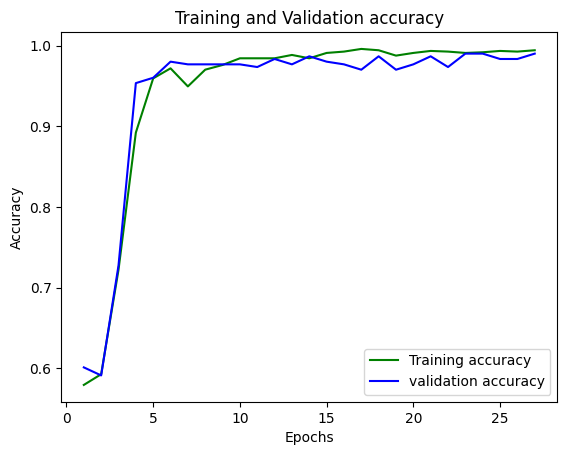

In [170]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,(len(loss_train)+1))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [171]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

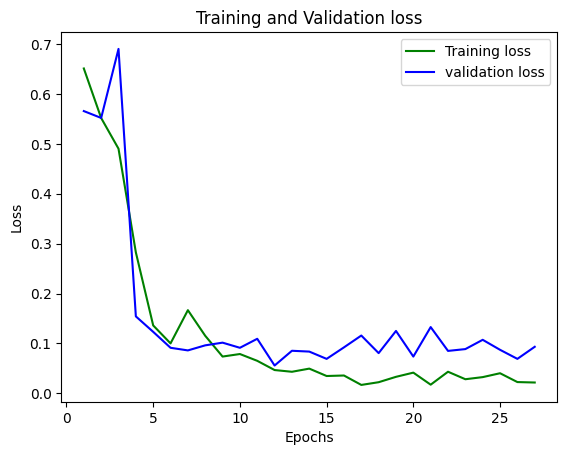

In [172]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,(len(loss_train)+1))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Model Evaluation

After training, the model's performance is evaluated on the test data using metrics like accuracy, precision, recall, and F1-score.


In [166]:
score=model.evaluate(X_test,y_test)
print(score)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0637 
[0.09337503463029861, 0.9900332093238831]


In [167]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [168]:
# Confusion Matrix for Custom CNN model
CM = confusion_matrix(y_true, y_pred)
print(CM)

[[179   2]
 [  1 119]]


In [169]:
# Classification Report for CNN model
target_names = ['class 0(Uninfected)', 'class 1(Parasitized)']
print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

 class 0(Uninfected)       0.99      0.99      0.99       181
class 1(Parasitized)       0.98      0.99      0.99       120

            accuracy                           0.99       301
           macro avg       0.99      0.99      0.99       301
        weighted avg       0.99      0.99      0.99       301



## Interactive Gradio Interface

To make this project more interactive, a Gradio interface has been implemented. Users can upload an image of a cell, and the model will predict whether the cell is infected with malaria or not.

In [173]:
# ! pip install gradio -q

In [174]:
import gradio as gr

In [ ]:
from PIL import Image
import os

def model_predict(img):
    img = Image.fromarray(img).resize((100, 100))
    img = np.array(img)
    if len(img.shape) == 2:  # If grayscale
        img = np.stack((img,) * 3, axis=-1)

    img = img.reshape(1, 100, 100, 3)
    single_pred = model.predict(img)[0]
    labels = os.listdir(data_path)
    predictions = {labels[i]: float(single_pred[i]) for i in range(len(single_pred))}

    return predictions


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# Malaria Cell Classification")
    gr.Markdown("Upload a cell image to determine if it is 'Parasitized' or 'Uninfected'.")

    with gr.Row():  # Arrange components horizontally
        with gr.Column(scale=1):  # Scale adjusts relative widths
            image_input = gr.Image(type="numpy", label="Upload Cell Image")  # Larger input
        with gr.Column(scale=1):
            label_output = gr.Label(label="Classification Results")  # Larger output

    submit_btn = gr.Button("Submit", size="lg")  # Larger button
    submit_btn.click(fn=model_predict, inputs=image_input, outputs=label_output)  # Link components

# Launch the demo
demo.launch(share=True)
